In [1]:
import sysconfig
import os
import numpy as np
import pandas as pd
import json
import distutils
import datetime
import scrapy
import requests
import json
import logging
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [2]:
!ls /Users/taj/GitHub/scraping/stayz/WebData/nsw_extract/

stayz_nsw_extract_2018-01-26.json.gz  stayz_nsw_extract_2018-03-10.json.gz
stayz_nsw_extract_2018-02-17.json.gz  stayz_nsw_extract_2018-03-11.json.gz
stayz_nsw_extract_2018-02-22.json.gz  stayz_nsw_extract_2018-03-12.json.zip
stayz_nsw_extract_2018-02-26.json.gz  stayz_nsw_extract_2018-03-13.json.zip
stayz_nsw_extract_2018-02-28.json.gz  stayz_nsw_extract_2018-03-14.json.zip
stayz_nsw_extract_2018-03-02.json.gz  stayz_nsw_extract_2018-03-15.json.zip
stayz_nsw_extract_2018-03-03.json.gz  stayz_nsw_extract_2018-03-16.json.zip
stayz_nsw_extract_2018-03-04.json.gz  stayz_nsw_extract_2018-03-17.json.zip
stayz_nsw_extract_2018-03-05.json.gz  stayz_nsw_extract_2018-03-18.json.zip
stayz_nsw_extract_2018-03-06.json.gz  stayz_nsw_extract_2018-03-19.json.zip
stayz_nsw_extract_2018-03-08.json.gz  stayz_nsw_extract_2018-03-20.json.zip
stayz_nsw_extract_2018-03-09.json.gz  stayz_nsw_extract_2018-03-21.json.zip
stayz_nsw_extract_2018-03-10.csv      stayz_nsw_extract_2018-03-22.json.zip
stayz_nsw_extr

In [18]:
#date_str = datetime.datetime.now().strftime("%Y-%m-%d")

date_str ='2018-03-22'

# Read the data file and display
nsw_data = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_extract/stayz_nsw_extract_' + date_str + '.json.zip')

nsw_data = nsw_data.reset_index(drop=True)
nsw_data = nsw_data.set_index('property_id')

# If the initial price is zero, set to NaN so it doesnt affect the statistics
nsw_data.loc[nsw_data['init_price'] == 0,'init_price'] = np.nan

nsw_data.head()

,bathrooms,bedrooms,beds,description_full,guests,heading,init_price,lat,lng,property_type,reviews,scraped_date,syd_brg,syd_brg_deg,syd_dist_km,url
property_id,,,,,,,,,,,,,,,,
9082944,2,3,7,"""The Best in Culburra "" Kate Nov 17",8,Escape@Culburra ABSOLUTE BEACH FRONT luxury be...,446.0,-34.933100,150.77500,House,174,2018-03-22 01:00:08,S,199,111,https://www.stayz.com.au//accommodation/nsw/so...
9140176,2,4,9,AWARDED AUSTRALIA'S TOP PET FRIENDLY RENTAL FO...,9,BLUE ISLAND - Award winning holiday home,242.0,-34.924686,150.76315,House,51,2018-03-22 01:00:08,S,200,110,https://www.stayz.com.au//accommodation/nsw/so...
9197130,3,3,3,Architecturally designed with bespoke interior...,6,140 Mitchell at Mollymook - Luxury Beach House,790.0,-35.324104,150.47970,House,22,2018-03-22 01:00:09,SW,203,161,https://www.stayz.com.au//accommodation/nsw/so...
9060297,2,2,2,La Petite Maison is perfectly stunning,4,La Petite Maison Leura- Blue Mountains,269.0,-33.714140,150.32840,Cottage,87,2018-03-22 01:00:09,W,291,84,https://www.stayz.com.au//accommodation/nsw/bl...
9132622,2,5,6,This is a cosy 4-5 bedroom cottage for $200/ni...,9,Millthorpe Cottage 18,204.0,-33.442738,149.18095,House,59,2018-03-22 01:00:09,W,287,194,https://www.stayz.com.au//accommodation/nsw/ex...


In [4]:
nsw_data.describe()

,bathrooms,bedrooms,beds,guests,init_price,lat,lng,reviews,syd_brg_deg,syd_dist_km
count,18157.000000,18157.000000,18157.000000,18157.000000,17915.000000,18157.000000,18157.000000,18157.000000,18157.000000,18157.000000
mean,1.852013,2.961502,4.278460,6.661508,313.021490,-33.180893,151.274946,5.675552,111.039985,226.119128
std,1.207840,1.610341,3.180739,3.860075,2349.784097,2.533160,4.566482,12.327407,107.070214,329.218611
min,0.000000,0.000000,0.000000,1.000000,1.000000,-41.453060,-100.945830,0.000000,0.000000,0.000000
25%,1.000000,2.000000,3.000000,4.000000,141.000000,-34.795284,150.534000,0.000000,22.000000,81.000000
50%,2.000000,3.000000,4.000000,6.000000,208.000000,-33.605840,151.270000,1.000000,32.000000,163.000000
75%,2.000000,4.000000,5.000000,8.000000,330.000000,-32.340940,152.465270,5.000000,203.000000,341.000000
max,50.000000,50.000000,100.000000,120.000000,312197.000000,41.970135,167.949000,193.000000,359.000000,15713.000000


In [5]:
# Filter for 4 or less guests
nsw_data_s1 = nsw_data.loc[nsw_data['guests'] <= 4]

# Filter for 4 or less bathrooms
nsw_data_s2 = nsw_data_s1.loc[nsw_data_s1['bathrooms'] <= 4 ]

# Fileter for 4 or less bedrooms
nsw_data_s3 = nsw_data_s2.loc[nsw_data_s2['beds'] <= 4 ]


nsw_data_s3.head()

,bathrooms,bedrooms,beds,description_full,guests,heading,init_price,lat,lng,property_type,reviews,scraped_date,syd_brg,syd_brg_deg,syd_dist_km,url
property_id,,,,,,,,,,,,,,,,
9060297,2,2,2,La Petite Maison is perfectly stunning,4,La Petite Maison Leura- Blue Mountains,269.0,-33.71414,150.32840,Cottage,87,2018-03-22 01:00:09,W,291,84,https://www.stayz.com.au//accommodation/nsw/bl...
9026665,1,2,3,Modern spacious ground floor apartment set in ...,4,50 Metres to the Beach...Byron Bay,208.0,-28.64100,153.61000,Apartment,15,2018-03-22 01:00:09,N,21,638,https://www.stayz.com.au//accommodation/nsw/no...
9060812,2,2,3,Our 4 cottages are set in a glorious bushland ...,4,TOUCHDOWN COTTAGES JINDABYNE,128.0,-36.42840,148.60300,Cottage,45,2018-03-22 01:00:09,SW,220,358,https://www.stayz.com.au//accommodation/nsw/sn...
9069072,2,2,2,"Surrounded by national parkland, with its own ...",4,The Treehouse - Hawkesbury River. Tranquil wat...,260.0,-33.43125,151.05113,House,75,2018-03-22 01:00:10,N,349,63,https://www.stayz.com.au//accommodation/nsw/sy...
9208330,1,1,1,MID WEEK SPECIAL RATE - Minimum two nights. Th...,2,Mill Paddock - Romantic Getaway,214.0,-33.45062,150.60938,Cottage,12,2018-03-22 01:00:10,NW,318,79,https://www.stayz.com.au//accommodation/nsw/bl...


In [6]:
# Testing - look in detail at any outliers

t1 = nsw_data_s3.loc[nsw_data_s3['init_price'] == 2200]
t1.head()

,bathrooms,bedrooms,beds,description_full,guests,heading,init_price,lat,lng,property_type,reviews,scraped_date,syd_brg,syd_brg_deg,syd_dist_km,url
property_id,,,,,,,,,,,,,,,,
176951,2,3,3,"Contemporary Hotels presents, The Coogee. A th...",4,THE COOGEE,2200.0,-33.923473,151.24829,House,0,2018-03-22 01:08:36,NE,40,9,https://www.stayz.com.au//accommodation/nsw/sy...


In [7]:
nsw_data_s3.describe()


,bathrooms,bedrooms,beds,guests,init_price,lat,lng,reviews,syd_brg_deg,syd_dist_km
count,4852.000000,4852.000000,4852.000000,4852.000000,4766.000000,4852.000000,4852.000000,4852.000000,4852.000000,4852.000000
mean,1.188788,1.582028,2.050289,3.329555,185.825220,-33.032877,151.088440,5.588829,104.562242,229.448269
std,0.416885,0.544145,0.874491,0.905564,108.660453,3.067691,7.695531,11.854341,111.267231,520.299258
min,0.000000,0.000000,0.000000,1.000000,14.000000,-41.293920,-84.997270,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,2.000000,122.000000,-34.278292,150.638745,0.000000,21.000000,39.000000
50%,1.000000,2.000000,2.000000,4.000000,168.000000,-33.722362,151.235840,1.000000,30.000000,135.000000
75%,1.000000,2.000000,3.000000,4.000000,224.000000,-32.180789,152.203390,5.000000,203.000000,348.000000
max,4.000000,5.000000,4.000000,4.000000,2200.000000,39.079407,153.635880,149.000000,359.000000,15713.000000


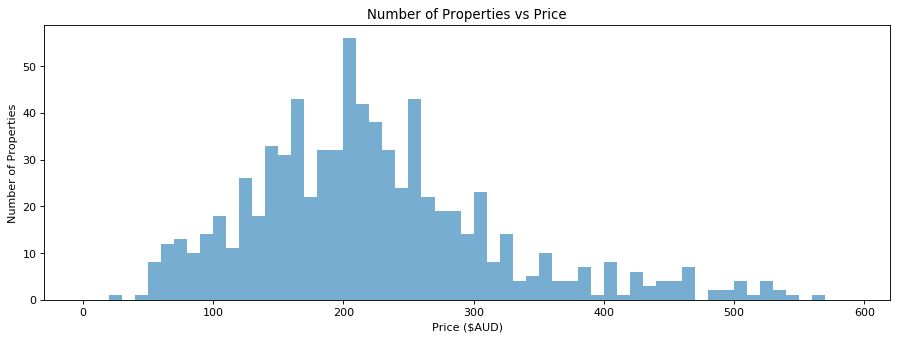

In [8]:
# Set the number of bars for the graph
bin_values = np.arange(start=0, stop=600, step=10)

# Create the figure
f1 = plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
ax = f1.add_subplot(221)
ax.set(title='Number of Properties vs Price'
      ,xlabel='Price ($AUD)'
      ,ylabel='Number of Properties')



# Filter to only 2 bedroom units:
tran_small_price1 = nsw_data_s3.loc[nsw_data_s3['bedrooms'] == 2]

# Filter where distance to Sydney between 100-150km
tran_small_price_local = tran_small_price1.loc[(tran_small_price1['syd_dist_km'] >= 100) & (tran_small_price1['syd_dist_km'] <= 150)]

tran_small_price_local = tran_small_price1.loc[(tran_small_price1['syd_brg'] == 'N')]


x = tran_small_price_local['init_price']

# Remove the rows where price is empty (NaN)
x = x.dropna()

ax.hist(x, bins=bin_values, alpha=.6) # alpha for transparency

plt.show()

In [9]:
tran_small_price_local.describe()

,bathrooms,bedrooms,beds,guests,init_price,lat,lng,reviews,syd_brg_deg,syd_dist_km
count,795.000000,795.0,795.000000,795.000000,778.000000,795.000000,795.000000,795.000000,795.000000,795.000000
mean,1.421384,2.0,2.489308,3.924528,232.047558,-31.862264,152.036990,4.748428,42.763522,250.784906
std,0.533319,0.0,0.594538,0.328096,127.479240,2.350784,1.066095,11.518340,91.488018,279.514135
min,1.000000,2.0,0.000000,2.000000,23.000000,-33.908756,150.885570,0.000000,0.000000,9.000000
25%,1.000000,2.0,2.000000,4.000000,158.000000,-33.826380,151.220645,0.000000,13.000000,18.000000
50%,1.000000,2.0,2.000000,4.000000,213.500000,-33.437096,151.334930,0.000000,19.000000,65.000000
75%,2.000000,2.0,3.000000,4.000000,270.750000,-28.788037,153.510265,4.000000,21.000000,621.500000
max,3.000000,2.0,4.000000,4.000000,1375.000000,-27.484535,153.635440,126.000000,359.000000,744.000000


Text(0,0.5,'Count')

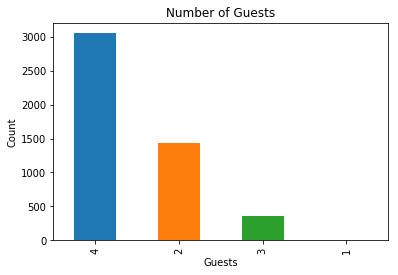

In [10]:
nsw_data_s3['guests'].value_counts().plot(kind='bar')
plt.title('Number of Guests')
plt.xlabel('Guests')
plt.ylabel('Count')

In [11]:
nsw_data_s3['guests'].groupby(nsw_data_s3['guests']).count()

guests
1       4
2    1441
3     359
4    3048
Name: guests, dtype: int64

In [12]:
train_display = pd.DataFrame({
    #'Nbr Reviews': train_small['reviews'],
    'Price': nsw_data_s3['init_price'],
    'Type': nsw_data_s3['property_type'],
    'Bathrooms' : nsw_data_s3['bathrooms'],
    'Beds' : nsw_data_s3['beds']
})

#train_display.groupby('Type').hist()

Geocoded Data

In [13]:
# Read the data file and display
geodata = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_geocoded/stayz_geocoded_2018-03-08.json')

geodata = geodata.reset_index(drop=True)
geodata = geodata.set_index('property_id')

geodata.head()


,council,formatted_address,postcode,st_name,st_nbr,state,suburb
property_id,,,,,,,
9080772,Snowy River,"17 Ingebyra St, Jindabyne NSW 2627, Australia",2627,Ingebyra St,17,NSW,Jindabyne
9117434,Great Lakes,"458 Coomba Rd, Whoota NSW 2428, Australia",2428,Coomba Rd,458,NSW,Whoota
9069770,Shoalhaven,"42 Penguins Head Rd, Culburra Beach NSW 2540, ...",2540,Penguins Head Rd,42,NSW,Culburra Beach
9071475,Blue Mountains,"9 Cross St, Blackheath NSW 2785, Australia",2785,Cross St,9,NSW,Blackheath
9006125,Snowy River,"Riverside Cabins, 23 Diggings Terrace, Koscius...",2625,Diggings Terrace,23,NSW,Kosciuszko National Park


In [14]:
# Merge the nsw_extract with the geocoded data:
full_dataset = nsw_data.merge(geodata, how='inner', left_index=True, right_index=True)

full_dataset.head()

,bathrooms,bedrooms,beds,description_full,guests,heading,init_price,lat,lng,property_type,...,syd_brg_deg,syd_dist_km,url,council,formatted_address,postcode,st_name,st_nbr,state,suburb
property_id,,,,,,,,,,,,,,,,,,,,,
9082944,2,3,7,"""The Best in Culburra "" Kate Nov 17",8,Escape@Culburra ABSOLUTE BEACH FRONT luxury be...,446.0,-34.933100,150.77500,House,...,199,111,https://www.stayz.com.au//accommodation/nsw/so...,Shoalhaven,"180-182 Penguins Head Rd, Culburra Beach NSW 2...",2540,Penguins Head Rd,180-182,NSW,Culburra Beach
9024318,3,7,11,Welcome to Orion's Lookout: Luxury accom in Je...,16,Orion's Lookout Jervis Bay,727.0,-35.071800,150.68400,House,...,200,128,https://www.stayz.com.au//accommodation/nsw/so...,Shoalhaven,"3-5 Minerva Ave, Vincentia NSW 2540, Australia",2540,Minerva Ave,3-5,NSW,Vincentia
9167523,2,4,6,BEAUTIFULLY DECORATED AND NEWLY RENOVATED HOME...,9,Callala Beach Pool House,342.0,-35.013344,150.68716,House,...,201,122,https://www.stayz.com.au//accommodation/nsw/so...,Shoalhaven,"13 Queen Mary St, Callala Beach NSW 2540, Aust...",2540,Queen Mary St,13,NSW,Callala Beach
9151070,2,4,5,Hank's at Mollymook comes equipped with everyt...,8,Hank's at Mollymook - family friendly,249.0,-35.340458,150.46426,House,...,203,163,https://www.stayz.com.au//accommodation/nsw/so...,Shoalhaven,"30 Ilett St, Mollymook NSW 2539, Australia",2539,Ilett St,30,NSW,Mollymook
9071475,1,2,5,Nestled high in a canopy of gum trees with stu...,5,Braeside Cabin Retreat,160.0,-33.640610,150.29774,Cabin,...,295,90,https://www.stayz.com.au//accommodation/nsw/bl...,Blue Mountains,"9 Cross St, Blackheath NSW 2785, Australia",2785,Cross St,9,NSW,Blackheath


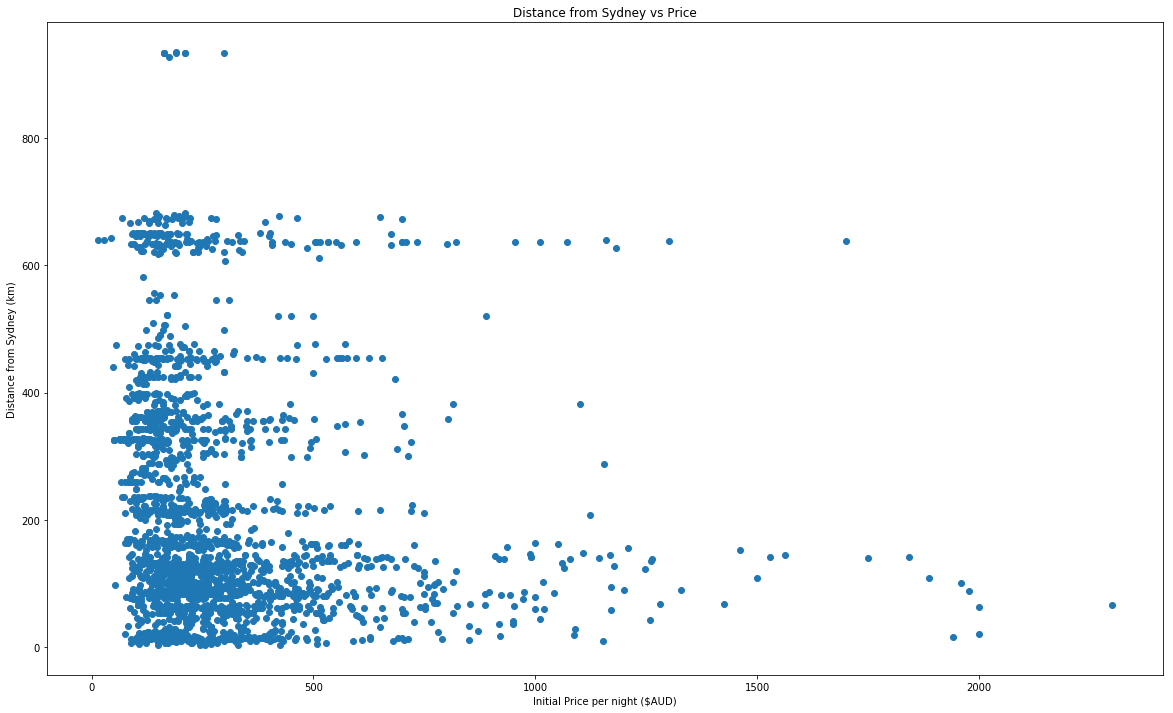

In [15]:
# Now draw a graph of Initial Price vs Distance from Sydney
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,12))

plt.title('Distance from Sydney vs Price')
plt.xlabel('Initial Price per night ($AUD)')
plt.ylabel('Distance from Sydney (km)')
plt.scatter(full_dataset['init_price'],full_dataset['syd_dist_km'])

plt.show()

In [20]:
# Now bring in the bookings details
# Read the bookings file
bk_date_str = '2018-03-12'

b = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_bookings/stayz_bookings_' + bk_date_str + '.json'
                ,convert_dates=['arr_dt','dep_dt'])

# Change the index to property id
b.set_index('property_id',inplace=True)

# Sort the dataset so that all property id bookings are together
b2 = b.sort_index()


# If the booking is greater than 7 days then may not be a customer
# If the booking is greater than 14 days then assume it is blocked out and not a booking
b2['book_type'] = b2['book_days'].map(lambda x: 'Host' if x > 14 else 'Cust')

b3 = b2[b2['book_type'] == 'Cust']

b3.tail(5)

,arr_dt,book_days,dep_dt,book_type
property_id,,,,
9228567,2018-03-30,4,2018-04-02,Cust
9228567,2018-03-10,3,2018-03-12,Cust
9228567,2018-06-22,3,2018-06-24,Cust
9228567,2018-05-25,3,2018-05-27,Cust
9228567,2018-04-12,4,2018-04-15,Cust


In [21]:
# Do a scatter plot of distance from sydney vs bookings count???

# Distance vs revenue?
# Distance vs revenue per person (assuming full occupancy)

# Percentage occupancy for the month vs distance
# 30/60/90 day occupancy vs distance (forward bookings)
# Las 30/60/90 day actual occupance vs distance (history bookings)

# Calculate the number of booked days for the 'Cust' type of bookings since b3 is the customers exc hosts
b5 = b3.groupby(['property_id']).sum()

# Rename the column as total_booked_days
b5.columns = ['total_booked_days']

b6 = b3.merge(b5, left_index=True, right_index=True)

b5.head()

,total_booked_days
property_id,
52,13
528,5
717,10
772,27
1036,29


In [22]:
# Check a particular property
b4 = b3.loc[9227458]

b4.head(20)

,arr_dt,book_days,dep_dt,book_type
property_id,,,,
9227458,2018-03-30,5,2018-04-03,Cust
9227458,2018-03-24,1,2018-03-25,Cust
9227458,2018-03-15,4,2018-03-18,Cust
9227458,2018-03-09,5,2018-03-13,Cust
9227458,2018-04-27,6,2018-05-02,Cust
9227458,2018-05-19,1,2018-05-20,Cust
9227458,2018-04-06,4,2018-04-09,Cust
9227458,2018-04-12,3,2018-04-14,Cust


In [24]:
# Join the full dataset with the bookings:

full_bookings = full_dataset.merge(b5, left_index=True, right_index=True)

full_bookings.head()

,bathrooms,bedrooms,beds,description_full,guests,heading,init_price,lat,lng,property_type,...,syd_dist_km,url,council,formatted_address,postcode,st_name,st_nbr,state,suburb,total_booked_days
property_id,,,,,,,,,,,,,,,,,,,,,
9024318,3,7,11,Welcome to Orion's Lookout: Luxury accom in Je...,16,Orion's Lookout Jervis Bay,727.0,-35.07180,150.68400,House,...,128,https://www.stayz.com.au//accommodation/nsw/so...,Shoalhaven,"3-5 Minerva Ave, Vincentia NSW 2540, Australia",2540,Minerva Ave,3-5,NSW,Vincentia,37
9069072,2,2,2,"Surrounded by national parkland, with its own ...",4,The Treehouse - Hawkesbury River. Tranquil wat...,260.0,-33.43125,151.05113,House,...,63,https://www.stayz.com.au//accommodation/nsw/sy...,Gosford,"6240 Wisemans Ferry Rd, Gunderman NSW 2775, Au...",2775,Wisemans Ferry Rd,6240,NSW,Gunderman,33
9067367,2,2,4,Quelle Vue is situated right in the heart of H...,6,Quelle Vue HUSKISSON,200.0,-35.03910,150.67065,Apartment,...,125,https://www.stayz.com.au//accommodation/nsw/so...,Shoalhaven,"62 Owen St, Huskisson NSW 2540, Australia",2540,Owen St,62,NSW,Huskisson,42
9050878,2,2,2,"Bantam Cottage is a cosy, cute, 100 year old, ...",4,"Bantam Cottage-a pet friendly, central location",191.0,-34.77690,150.69900,Cottage,...,98,https://www.stayz.com.au//accommodation/nsw/so...,Shoalhaven,"32 Prince Alfred St, Berry NSW 2535, Australia",2535,Prince Alfred St,32,NSW,Berry,74
9085873,1,2,3,Rosenthal Farm Retreat offers a contemporary r...,4,Contemporary stylish luxury retreat featuring ...,227.0,-35.32290,150.38800,House,...,165,https://www.stayz.com.au//accommodation/nsw/so...,Shoalhaven,"563 Croobyar Rd, Croobyar NSW 2539, Australia",2539,Croobyar Rd,563,NSW,Croobyar,27


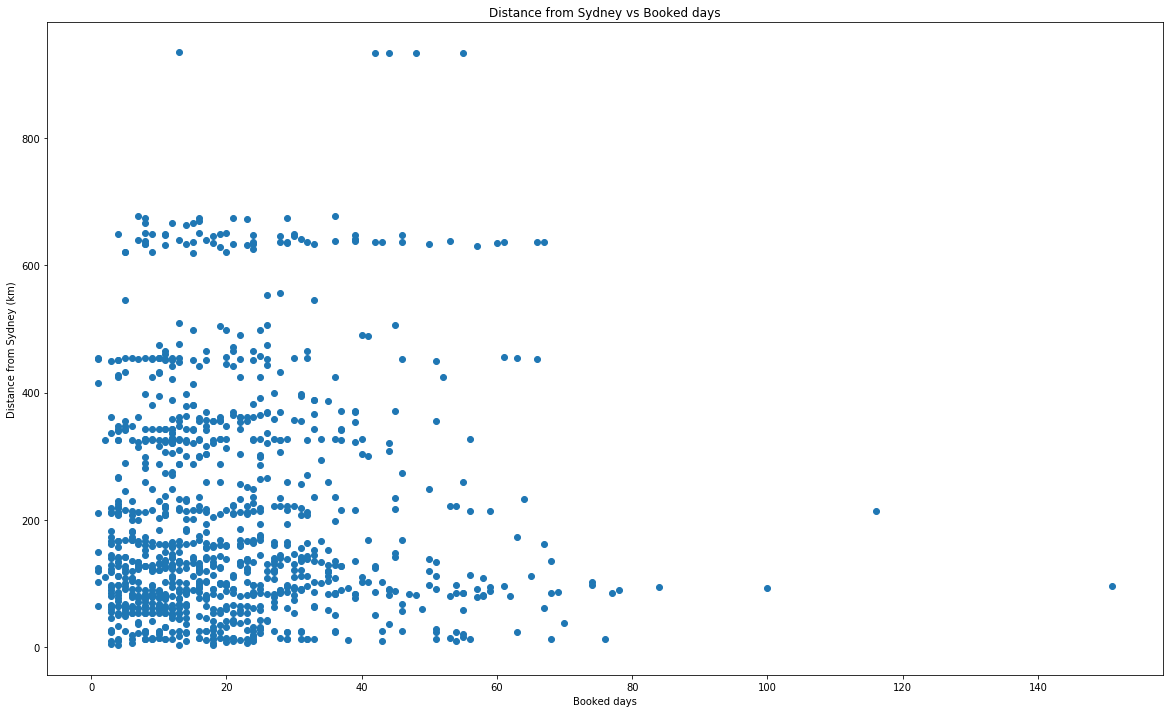

In [26]:
# Plot the distance vs booking days
plt.figure(figsize=(20,12))

plt.title('Distance from Sydney vs Booked days')
plt.xlabel('Booked days')
plt.ylabel('Distance from Sydney (km)')
plt.scatter(full_bookings['total_booked_days'],full_bookings['syd_dist_km'])

plt.show()

In [40]:
test_cor = full_bookings.corr(method='pearson')

test_cor

,bathrooms,bedrooms,beds,guests,init_price,lat,lng,reviews,syd_brg_deg,syd_dist_km,postcode,total_booked_days
bathrooms,1.000000,0.704809,0.610912,0.698638,0.616101,-0.010163,-0.012483,0.038858,0.023930,-0.065996,0.013212,0.132248
bedrooms,0.704809,1.000000,0.835374,0.875703,0.565720,-0.031893,-0.027246,0.021489,0.105415,-0.037850,0.077405,0.135670
beds,0.610912,0.835374,1.000000,0.883874,0.462369,-0.070171,-0.031940,0.026667,0.109826,-0.064677,0.046201,0.120111
guests,0.698638,0.875703,0.883874,1.000000,0.581565,-0.070999,-0.048165,0.019658,0.105666,-0.076773,0.042666,0.137576
init_price,0.616101,0.565720,0.462369,0.581565,1.000000,-0.013845,0.009487,-0.006349,-0.039399,-0.195608,-0.091581,0.112199
lat,-0.010163,-0.031893,-0.070171,-0.070999,-0.013845,1.000000,0.706131,-0.054926,-0.531760,0.540459,-0.137280,0.078055
lng,-0.012483,-0.027246,-0.031940,-0.048165,0.009487,0.706131,1.000000,-0.022328,-0.662804,0.186810,-0.423070,-0.065640
reviews,0.038858,0.021489,0.026667,0.019658,-0.006349,-0.054926,-0.022328,1.000000,0.054586,-0.081899,0.066186,0.177018
syd_brg_deg,0.023930,0.105415,0.109826,0.105666,-0.039399,-0.531760,-0.662804,0.054586,1.000000,-0.202001,0.618708,0.116438
syd_dist_km,-0.065996,-0.037850,-0.064677,-0.076773,-0.195608,0.540459,0.186810,-0.081899,-0.202001,1.000000,0.313291,0.034229


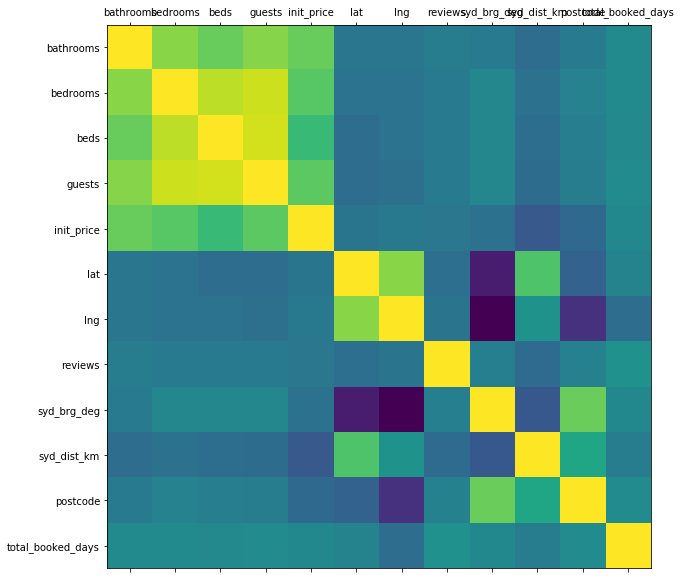

In [42]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
plot_corr(full_bookings)